# Shallow Water Equation

## Derive the 1D shallow water equation with conservative variables


The final form of the Navier-Stokes equation in 3D are:
\begin{align}
\nabla \textbf{v} = 0
\end{align}

\begin{align}
\frac{\partial }{\partial t} \rho \textbf{v} + \nabla (\rho \textbf{v} \textbf{v}) = - \nabla p + \rho g + \nabla \textbf{{T}}
\end{align}



\begin{align}
    \frac{\partial H}{\partial t} + \frac{\partial (Hu) }{\partial x} = 0
\end{align}

\begin{align}
    \frac{\partial }{\partial t} (Hu) + \frac{\partial }{\partial x} \left( Hu^2 + \frac{1}{2} gH^2 \right) = - g H \frac{\partial \zeta }{\partial x} + \frac{1}{\rho} \left( \tau_{sx} - \tau_{bx} + F_x \right),
\end{align}
where $H$ is the water depth, $u$ is the velocity in the $x-$ direction, $\zeta$ is the water surface elevation, $\tau_{sx}$ is the surface stress in the $x-$ direction, $\tau_{bx}$ is the bottom friction in the $x-$ direction and $F_x$ represents other external forces in the $x-$ direction.

For simplicity, we will begin by neglecting the term $- g H \frac{\partial \zeta }{\partial x} + \frac{1}{\rho} \left( \tau_{sx} - \tau_{bx} + F_x \right)$.


Matrix form:
\begin{align}
U_t + F(U)_x  = 0,
\end{align}
where 
\begin{align}
U = \begin{bmatrix}
H \\ Hu
\end{bmatrix}, \quad F(U) = \begin{bmatrix}
Hu \\ Hu^2 + 1/2gH^2
\end{bmatrix}
\end{align}





Use:
\begin{align}
U_{i}^{t+1} = U_{i}^t - \frac{\Delta t}{2 \Delta x} (F_{i+1}^t - F_{i-1}^t)
\end{align}

## Solve the 1D SWE using the Finite Volume Method with a Riemann solver



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation


In [4]:
# Functions
def roe_average(U_L, U_R):
    h_L, hu_L = U_L
    h_R, hu_R = U_R
    u_L = hu_L / h_L
    u_R = hu_R / h_R
    h_tilde = (h_L + h_R) / 2
    u_tilde = (np.sqrt(h_L) * u_L + np.sqrt(h_R) * u_R) / (np.sqrt(h_L) + np.sqrt(h_R))
    return h_tilde, u_tilde

def roe_flux(U_L, U_R, h_tilde, u_tilde, g):
    # Extract variables
    h_L, hu_L = U_L
    h_R, hu_R = U_R
    u_L = hu_L / h_L
    u_R = hu_R / h_R

    # Compute fluxes for left and right states
    F_L = [hu_L, hu_L * u_L + 0.5 * g * h_L**2]
    F_R = [hu_R, hu_R * u_R + 0.5 * g * h_R**2]
    
    # Compute eigenvalues and eigenvectors
    lambda1 = u_tilde - np.sqrt(g * h_tilde)
    lambda2 = u_tilde + np.sqrt(g * h_tilde)
    
    # Compute Roe flux
    flux = 0.5 * (F_L + F_R) - 0.5 * abs(lambda1) * (U_R - U_L) - 0.5 * abs(lambda2) * (U_R - U_L)
    return flux

def compute_fluxes(U, g):
    F = []
    for i in range(N+1):
        # Compute Roe-averaged state
        h_tilde, u_tilde = roe_average(U[i], U[i+1])
        
        # Compute flux using Roe solver
        F.append(roe_flux(U[i], U[i+1], h_tilde, u_tilde, g))
    return F

def max_velocity(U, g, N):
    max_vel = 0
    for i in range(N):
        h, hu = U[i]
        u = hu / h
        max_vel = max(max_vel, abs(u) + np.sqrt(g * h))
    return max_vel



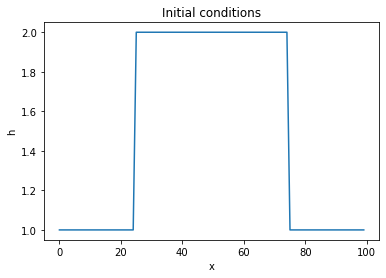

In [9]:
# Initialization
N = 100 # Number of grid points
L = 10 # Length of the domain
dx = L / N

CFL = 0.9 # CFL number
g = 9.81 # Gravity

t_end = 10

# Initial conditions
h = np.ones(N)
hu = np.zeros(N)
u = np.zeros(N)

h[int(N/4):int(3*N/4)] = 2.0  # higher water level in the middle

plt.plot(h)
plt.xlabel('x')
plt.ylabel('h')
plt.title('Initial conditions')
plt.show()


In [16]:
# Function to calculate fluxes
def flux(h, hu, g):
    u = hu / h
    F = np.zeros((2, N))
    F[0, :] = hu
    F[1, :] = hu * u + 0.5 * g * h**2
    return F

F = flux(h, hu, g)


In the Roe solver we calculate:
\begin{align}
    h_{i+1/2} = \frac{H_l + H_r}{2}
\end{align} 

\begin{align}
u_{i+1/2} = \frac{\sqrt{H_l}u_l + \sqrt{H_r}u_r }{\sqrt{H_l} + \sqrt{H_r}}
\end{align}

In [20]:
# Implement the Riemann solver
def roe_solver(hL, huL, hR, huR):
    # Calculate Roe averages
    h_tilde = (hL + hR) / 2
    u_tilde = (np.sqrt(hL) * huL / hL + np.sqrt(hR) * huR / hR) / (np.sqrt(hL) + np.sqrt(hR))

    c = np.sqrt(g * h_tilde)

    # Calculate eigenvalues
    lambda1 = u_tilde - c
    lambda2 = u_tilde + c

    # Compute fluxes
    F_L = np.array([huL, huL**2 / hL + 0.5 * g * hL**2])
    F_R = np.array([huR, huR**2 / hR + 0.5 * g * hR**2])

    # Difference 
    dU = np.array([hR - hL, huR - huL])

    # Compute Roe flux
    if lambda1 >= 0 and lambda2 >= 0:
        return F_L
    elif lambda1 < 0 and lambda2 > 0:
        return 0.5 * (F_L + F_R) - 0.5* c * dU
    else:
        return F_R
    

# Calculate the flux at each interface
def compute_interface_fluxes(h, hu, N):
    fluxes = np.zeros((2, N+1))
    for i in range(1,N):
        fluxes[:,i] = roe_solver(h[i-1], hu[i-1], h[i], hu[i])
    return fluxes

# Time integration
def update_variables(h, hu, dt, fluxes):
    for i in range(1, N-1):
        h[i] = h[i] - dt/dx * (fluxes[0, i+1] - fluxes[0, i])
        hu[i] = hu[i] - dt/dx * (fluxes[1, i+1] - fluxes[1, i])
    return h, hu

In [89]:
# Function to visualize
def subplot(h_hist,idx):
    idx1,idx2,idx3 = idx
    plt.figure(figsize=(17,5))
    plt.subplot(1,3,1)
    plt.plot(np.linspace(0, L, N), h_hist[idx1])
    plt.xlabel('Distance (x)')
    plt.ylabel('Water Height (h)')
    plt.title(f'Time step {idx1}/{len(h_hist) - 1}')

    plt.subplot(1,3,2)
    plt.plot(np.linspace(0, L, N), h_hist[idx2])
    plt.xlabel('Distance (x)')
    plt.ylabel('Water Height (h)')
    plt.title(f'Time step {idx2}/{len(h_hist) - 1}')

    plt.subplot(1,3,3)
    plt.plot(np.linspace(0, L, N), h_hist[idx3])
    plt.xlabel('Distance (x)')
    plt.ylabel('Water Height (h)')
    plt.title(f'Time step {idx3}/{len(h_hist) - 1}')

    plt.show()
    return

Number of time steps:
59


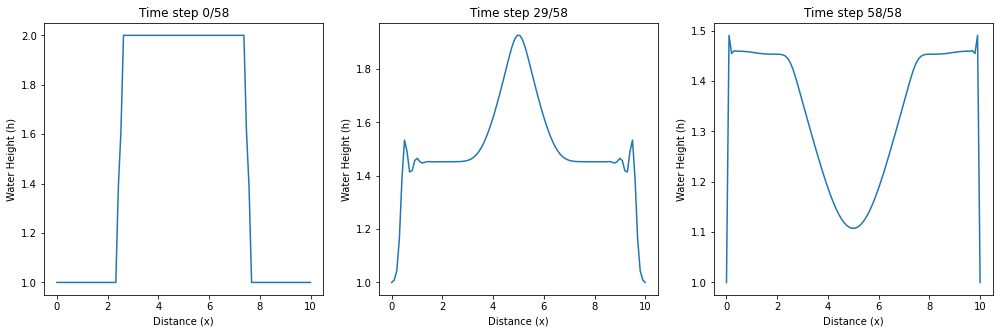

In [94]:
# Initialization
N = 100 # Number of grid points
L = 10 # Length of the domain
dx = L / N

CFL = 0.9 # CFL number
g = 9.81 # Gravity


# Initial conditions
h = np.ones(N)
hu = np.zeros(N)
u = np.zeros(N)

h[int(N/4):int(3*N/4)] = 2.0  # higher water level in the middle

t = 0
t_end = 1

# Store the intermediate states
h_hist = []
dt_hist = []

# Main loop
while t < t_end:
    # Compute time step size 
    u = hu/h
    c = np.sqrt(g*h)
    dt = CFL * dx/ np.max(np.abs(u) + c)

    if t + dt > t_end:
        dt = t_end - t
    
    # Compute fluxes at interfaces
    fluxes = compute_interface_fluxes(h, hu, N)
    
    # Update variables
    h, hu = update_variables(h, hu, dt, fluxes)
    h_hist.append(h.copy())
    dt_hist.append(dt)
    
    t += dt

n = len(dt_hist)

print('Number of time steps:')
print(n)


# Make 3 subplots
idx = [0,int(n/2),n-1]
subplot(h_hist,idx)

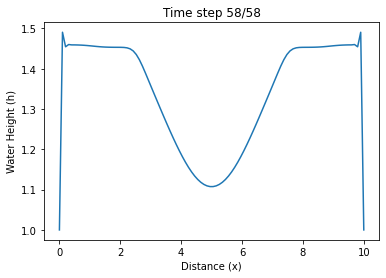

In [75]:
# Create animation
fig, ax = plt.subplots()

def update_plot(index):
    ax.clear()
    ax.plot(np.linspace(0, L, N), h_hist[index])
    ax.set_xlabel('Distance (x)')
    ax.set_ylabel('Water Height (h)')
    ax.set_title(f'Time step {index}/{len(h_hist) - 1}')

ani = animation.FuncAnimation(fig, update_plot, frames=len(h_hist), interval=100)

# Display the animation
from IPython.display import HTML
HTML(ani.to_jshtml())
